In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# Parâmetros do sistema
lambda_ = 9.5
mu = 10
valor_teorico = lambda_ / (mu * (mu - lambda_ / mu))  # E[X]
gamma = 0.05  # precisão relativa de 5%
alpha = 0.05  # nível de confiança (95%)
z = st.norm.ppf(1 - alpha / 2)


In [28]:
def mser5y_eliminacao(epsilons, min_burn_in=100, janela=5):
    medias_movel = np.convolve(epsilons, np.ones(janela)/janela, mode='valid')
    diffs = np.abs(np.diff(medias_movel))
    if len(diffs) < min_burn_in:
        return min_burn_in
    for i in range(min_burn_in, len(diffs)):
        if np.all(diffs[i-janela+1:i+1] < 1e-3):
            return i
    return min_burn_in

In [29]:
esperas = []
chegada = 0
fim_servico = 0
n = 0

while True:
    chegada += np.random.exponential(1 / lambda_)
    servico = np.random.exponential(1 / mu)
    inicio = max(chegada, fim_servico)
    fim_servico = inicio + servico
    espera = inicio - chegada
    esperas.append(espera)
    n += 1

    if n >= 500:
        burnin = mser5y_eliminacao(np.array(esperas), janela=5)
        estacionario = np.array(esperas[burnin:])
        media = np.mean(estacionario)
        std = np.std(estacionario, ddof=1)
        erro = z * std / np.sqrt(len(estacionario))

        if erro / media <= gamma:
            break


## Código da solução anterior de Conway/Fishman

In [30]:
def simular_mm1(lambd, mu, n_total):
    inter_arrival = np.random.exponential(1 / lambd, n_total)
    service = np.random.exponential(1 / mu, n_total)
    arrival = np.cumsum(inter_arrival)
    start = np.zeros(n_total)
    finish = np.zeros(n_total)
    wait = np.zeros(n_total)

    for i in range(n_total):
        start[i] = max(arrival[i], finish[i - 1]) if i > 0 else arrival[i]
        finish[i] = start[i] + service[i]
        wait[i] = start[i] - arrival[i]
    return wait

# Configurações
lambd = 9.5
mu = 10
valor_teorico = 1.9
r = 30
n_total_conway = 2000
n_total_fishman = 5000
n_amostral = 1000
bloco_tam = 100
gamma_fishman = 0.01

# ----- Conway -----
replicas_conway = np.zeros((r, n_total_conway))
for i in range(r):
    replicas_conway[i] = simular_mm1(lambd, mu, n_total_conway)

variancia_por_tempo = np.var(replicas_conway, axis=0)
window = 20
delta_max = 0.001
cut_point_conway = next(
    (t for t in range(window, n_total_conway - window)
     if abs(np.mean(variancia_por_tempo[t:t + window]) - np.mean(variancia_por_tempo[t - window:t])) < delta_max),
    n_total_conway // 4
)

x_medias_conway = [
    np.mean(replicas_conway[i, cut_point_conway:cut_point_conway + n_amostral])
    for i in range(r)
]

# ----- Fishman -----
medias_fishman = []

for _ in range(r):
    esperas = simular_mm1(lambd, mu, n_total_fishman)
    num_blocos = n_total_fishman // bloco_tam
    medias_blocos = [np.mean(esperas[i * bloco_tam:(i + 1) * bloco_tam]) for i in range(num_blocos)]

    cut_point_fishman = next(
        (i * bloco_tam for i in range(1, num_blocos - 1)
         if abs(medias_blocos[i] - medias_blocos[i - 1]) < gamma_fishman),
        bloco_tam * 2
    )

    dados_estacionarios = esperas[cut_point_fishman:cut_point_fishman + n_amostral]
    media = np.mean(dados_estacionarios)
    medias_fishman.append(media)


In [31]:
print(f"\n--- MSER-5Y ---")
print(f"n final: {n}")
print(f"Burn-in (MSER-5Y): {burnin}")
print(f"Tempo médio de espera: {media:.5f}")
print(f"Intervalo de confiança 95%: ±{erro:.5f}")
print(f"Valor teórico: {valor_teorico:.5f}")



--- MSER-5Y ---
n final: 1344
Burn-in (MSER-5Y): 100
Tempo médio de espera: 1.37525
Intervalo de confiança 95%: ±0.03227
Valor teórico: 1.90000


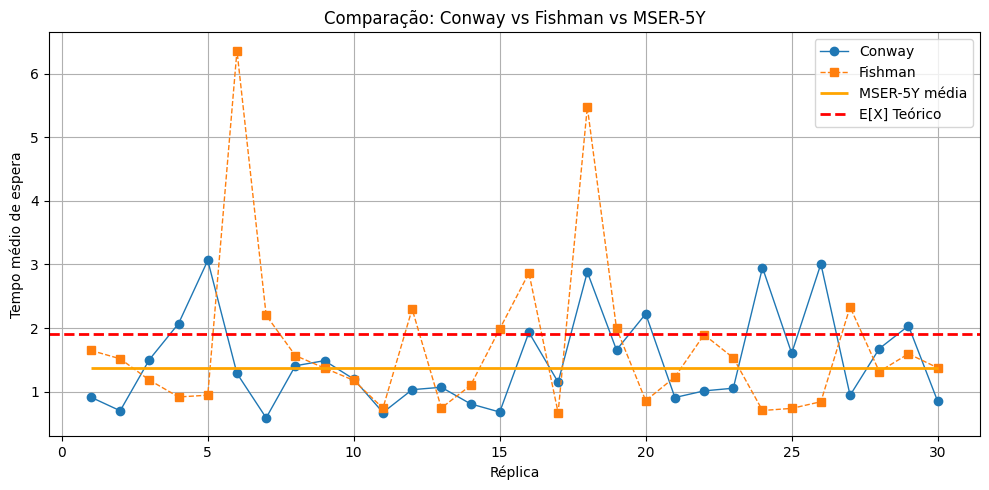

In [32]:
replicas = list(range(1, len(x_medias_conway) + 1))

plt.figure(figsize=(10, 5))
plt.plot(replicas, x_medias_conway, marker='o', label='Conway', linestyle='-', linewidth=1)
plt.plot(replicas, medias_fishman, marker='s', label='Fishman', linestyle='--', linewidth=1)
plt.hlines(media, 1, len(replicas), colors='orange', linestyles='-', label='MSER-5Y média', linewidth=2)
plt.axhline(valor_teorico, color='red', linestyle='--', label='E[X] Teórico', linewidth=2)

plt.xlabel('Réplica')
plt.ylabel('Tempo médio de espera')
plt.title('Comparação: Conway vs Fishman vs MSER-5Y')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
